# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.454149070554495 -2.693646608267474
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # targetQs/nextQs
    gloss = tf.reduce_mean(-gQs) # DPG
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [20]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, _ = sess.run([model.d_lossA, model.d_optA],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0000 rate:0.0460 gloss:0.0683 dlossA:1.0008 dlossQ:0.1410 exploreP:0.9977
Episode:1 meanR:19.5000 R:16.0000 rate:0.0320 gloss:0.0606 dlossA:1.0031 dlossQ:0.1401 exploreP:0.9961
Episode:2 meanR:21.6667 R:26.0000 rate:0.0520 gloss:0.0575 dlossA:1.0017 dlossQ:0.1466 exploreP:0.9936
Episode:3 meanR:21.2500 R:20.0000 rate:0.0400 gloss:0.0783 dlossA:0.9956 dlossQ:0.1548 exploreP:0.9916
Episode:4 meanR:20.8000 R:19.0000 rate:0.0380 gloss:0.0674 dlossA:0.9817 dlossQ:0.1699 exploreP:0.9898
Episode:5 meanR:21.3333 R:24.0000 rate:0.0480 gloss:0.0946 dlossA:0.9754 dlossQ:0.1622 exploreP:0.9874
Episode:6 meanR:21.4286 R:22.0000 rate:0.0440 gloss:0.0548 dlossA:0.9831 dlossQ:0.1793 exploreP:0.9853
Episode:7 meanR:21.6250 R:23.0000 rate:0.0460 gloss:0.0918 dlossA:0.9732 dlossQ:0.1682 exploreP:0.9830
Episode:8 meanR:21.3333 R:19.0000 rate:0.0380 gloss:0.0370 dlossA:0.9874 dlossQ:0.1790 exploreP:0.9812
Episode:9 meanR:20.6000 R:14.0000 rate:0.0280 gloss:0.0451 dlossA:0.9883 

Episode:79 meanR:23.5250 R:24.0000 rate:0.0480 gloss:-4.9598 dlossA:1.6379 dlossQ:18.6816 exploreP:0.8302
Episode:80 meanR:23.6914 R:37.0000 rate:0.0740 gloss:-5.4094 dlossA:1.6536 dlossQ:21.8525 exploreP:0.8271
Episode:81 meanR:23.7195 R:26.0000 rate:0.0520 gloss:-5.8629 dlossA:1.6440 dlossQ:27.3633 exploreP:0.8250
Episode:82 meanR:23.6265 R:16.0000 rate:0.0320 gloss:-6.0306 dlossA:1.7807 dlossQ:27.1749 exploreP:0.8237
Episode:83 meanR:23.6548 R:26.0000 rate:0.0520 gloss:-6.2490 dlossA:1.7341 dlossQ:29.8294 exploreP:0.8216
Episode:84 meanR:23.7529 R:32.0000 rate:0.0640 gloss:-6.3607 dlossA:1.7747 dlossQ:29.6153 exploreP:0.8190
Episode:85 meanR:24.0465 R:49.0000 rate:0.0980 gloss:-6.9725 dlossA:1.7806 dlossQ:37.5613 exploreP:0.8151
Episode:86 meanR:23.9540 R:16.0000 rate:0.0320 gloss:-7.4543 dlossA:1.7700 dlossQ:43.8752 exploreP:0.8138
Episode:87 meanR:23.8068 R:11.0000 rate:0.0220 gloss:-7.9892 dlossA:1.8633 dlossQ:48.4832 exploreP:0.8129
Episode:88 meanR:23.6854 R:13.0000 rate:0.0260

Episode:155 meanR:20.8600 R:11.0000 rate:0.0220 gloss:-58.3617 dlossA:3.4183 dlossQ:3015.5483 exploreP:0.7123
Episode:156 meanR:21.0800 R:35.0000 rate:0.0700 gloss:-58.5498 dlossA:3.4864 dlossQ:2922.8220 exploreP:0.7099
Episode:157 meanR:20.9800 R:13.0000 rate:0.0260 gloss:-63.8286 dlossA:3.5686 dlossQ:3608.3635 exploreP:0.7090
Episode:158 meanR:20.8900 R:22.0000 rate:0.0440 gloss:-62.5043 dlossA:3.5954 dlossQ:3214.1672 exploreP:0.7074
Episode:159 meanR:20.8900 R:21.0000 rate:0.0420 gloss:-62.1975 dlossA:3.5263 dlossQ:3389.3408 exploreP:0.7060
Episode:160 meanR:20.8400 R:11.0000 rate:0.0220 gloss:-64.9512 dlossA:3.5599 dlossQ:3721.3225 exploreP:0.7052
Episode:161 meanR:20.2100 R:21.0000 rate:0.0420 gloss:-68.0816 dlossA:3.6282 dlossQ:4055.4431 exploreP:0.7037
Episode:162 meanR:20.2400 R:20.0000 rate:0.0400 gloss:-68.2610 dlossA:3.6138 dlossQ:4118.0688 exploreP:0.7024
Episode:163 meanR:20.1900 R:11.0000 rate:0.0220 gloss:-67.6878 dlossA:3.5426 dlossQ:3783.0977 exploreP:0.7016
Episode:16

Episode:229 meanR:18.3900 R:17.0000 rate:0.0340 gloss:-233.7293 dlossA:5.5803 dlossQ:50556.3594 exploreP:0.6243
Episode:230 meanR:18.3700 R:17.0000 rate:0.0340 gloss:-241.0725 dlossA:5.6390 dlossQ:51868.7383 exploreP:0.6232
Episode:231 meanR:18.0800 R:16.0000 rate:0.0320 gloss:-239.7431 dlossA:5.3068 dlossQ:52740.9766 exploreP:0.6222
Episode:232 meanR:17.9700 R:15.0000 rate:0.0300 gloss:-246.9836 dlossA:5.5703 dlossQ:56378.8086 exploreP:0.6213
Episode:233 meanR:18.0000 R:13.0000 rate:0.0260 gloss:-249.2171 dlossA:5.5850 dlossQ:55873.8086 exploreP:0.6205
Episode:234 meanR:17.9300 R:13.0000 rate:0.0260 gloss:-250.5641 dlossA:5.5872 dlossQ:57358.5820 exploreP:0.6197
Episode:235 meanR:17.9000 R:20.0000 rate:0.0400 gloss:-249.8355 dlossA:5.4873 dlossQ:57695.0234 exploreP:0.6185
Episode:236 meanR:18.0400 R:37.0000 rate:0.0740 gloss:-267.5080 dlossA:5.7159 dlossQ:64184.1016 exploreP:0.6163
Episode:237 meanR:17.9800 R:12.0000 rate:0.0240 gloss:-258.5962 dlossA:5.6158 dlossQ:61170.2227 exploreP

Episode:302 meanR:21.4300 R:33.0000 rate:0.0660 gloss:-855.9359 dlossA:8.2471 dlossQ:671313.9375 exploreP:0.5310
Episode:303 meanR:21.6700 R:43.0000 rate:0.0860 gloss:-871.0955 dlossA:8.4246 dlossQ:709205.8125 exploreP:0.5287
Episode:304 meanR:21.7300 R:21.0000 rate:0.0420 gloss:-878.8115 dlossA:8.4559 dlossQ:698394.8750 exploreP:0.5277
Episode:305 meanR:21.9400 R:35.0000 rate:0.0700 gloss:-889.2119 dlossA:8.4082 dlossQ:739753.7500 exploreP:0.5258
Episode:306 meanR:21.8100 R:34.0000 rate:0.0680 gloss:-916.7883 dlossA:8.4529 dlossQ:783142.6875 exploreP:0.5241
Episode:307 meanR:22.0200 R:31.0000 rate:0.0620 gloss:-940.3130 dlossA:8.3873 dlossQ:822169.6250 exploreP:0.5225
Episode:308 meanR:22.0200 R:31.0000 rate:0.0620 gloss:-965.5115 dlossA:8.4245 dlossQ:860787.7500 exploreP:0.5209
Episode:309 meanR:22.1600 R:30.0000 rate:0.0600 gloss:-989.9768 dlossA:8.6836 dlossQ:922280.8125 exploreP:0.5194
Episode:310 meanR:22.2100 R:20.0000 rate:0.0400 gloss:-986.0539 dlossA:8.5755 dlossQ:916510.6875

Episode:373 meanR:37.4100 R:16.0000 rate:0.0320 gloss:-4450.9146 dlossA:13.5981 dlossQ:18780328.0000 exploreP:0.3965
Episode:374 meanR:37.3700 R:18.0000 rate:0.0360 gloss:-4461.6147 dlossA:13.3898 dlossQ:18548848.0000 exploreP:0.3958
Episode:375 meanR:37.3900 R:28.0000 rate:0.0560 gloss:-4513.6084 dlossA:13.7330 dlossQ:19145370.0000 exploreP:0.3947
Episode:376 meanR:37.4200 R:21.0000 rate:0.0420 gloss:-4547.0728 dlossA:13.8687 dlossQ:17561404.0000 exploreP:0.3939
Episode:377 meanR:37.0100 R:30.0000 rate:0.0600 gloss:-4630.7891 dlossA:14.0232 dlossQ:20294524.0000 exploreP:0.3928
Episode:378 meanR:37.0300 R:21.0000 rate:0.0420 gloss:-4677.8047 dlossA:13.6935 dlossQ:20856618.0000 exploreP:0.3920
Episode:379 meanR:36.9700 R:18.0000 rate:0.0360 gloss:-4688.6670 dlossA:13.6704 dlossQ:20886402.0000 exploreP:0.3913
Episode:380 meanR:36.9400 R:19.0000 rate:0.0380 gloss:-4787.3438 dlossA:13.9425 dlossQ:21064224.0000 exploreP:0.3905
Episode:381 meanR:36.9700 R:23.0000 rate:0.0460 gloss:-4854.3579

Episode:444 meanR:22.1200 R:15.0000 rate:0.0300 gloss:-7876.3809 dlossA:16.1028 dlossQ:59524564.0000 exploreP:0.3488
Episode:445 meanR:21.9500 R:12.0000 rate:0.0240 gloss:-7995.1187 dlossA:15.9559 dlossQ:59561884.0000 exploreP:0.3484
Episode:446 meanR:21.8200 R:19.0000 rate:0.0380 gloss:-7997.3403 dlossA:16.3316 dlossQ:57544636.0000 exploreP:0.3477
Episode:447 meanR:21.5500 R:20.0000 rate:0.0400 gloss:-8020.8179 dlossA:16.8400 dlossQ:60460320.0000 exploreP:0.3470
Episode:448 meanR:20.9300 R:13.0000 rate:0.0260 gloss:-8054.0620 dlossA:15.8191 dlossQ:61026668.0000 exploreP:0.3466
Episode:449 meanR:20.7800 R:11.0000 rate:0.0220 gloss:-8112.5439 dlossA:16.1055 dlossQ:63040924.0000 exploreP:0.3462
Episode:450 meanR:20.7800 R:19.0000 rate:0.0380 gloss:-8214.2207 dlossA:16.9117 dlossQ:63834456.0000 exploreP:0.3456
Episode:451 meanR:20.5400 R:12.0000 rate:0.0240 gloss:-8202.8037 dlossA:17.4388 dlossQ:63694796.0000 exploreP:0.3452
Episode:452 meanR:20.5000 R:18.0000 rate:0.0360 gloss:-8309.0859

Episode:514 meanR:14.4200 R:12.0000 rate:0.0240 gloss:-11476.4170 dlossA:18.7364 dlossQ:125234112.0000 exploreP:0.3183
Episode:515 meanR:14.4000 R:14.0000 rate:0.0280 gloss:-11428.4355 dlossA:17.1542 dlossQ:123531240.0000 exploreP:0.3179
Episode:516 meanR:14.3700 R:20.0000 rate:0.0400 gloss:-11568.8750 dlossA:18.4487 dlossQ:126507392.0000 exploreP:0.3173
Episode:517 meanR:14.3000 R:11.0000 rate:0.0220 gloss:-11509.9541 dlossA:19.1623 dlossQ:119031264.0000 exploreP:0.3170
Episode:518 meanR:14.2700 R:12.0000 rate:0.0240 gloss:-11616.8516 dlossA:18.6565 dlossQ:125382600.0000 exploreP:0.3166
Episode:519 meanR:14.2800 R:13.0000 rate:0.0260 gloss:-11579.3291 dlossA:17.0583 dlossQ:113270560.0000 exploreP:0.3162
Episode:520 meanR:14.2800 R:19.0000 rate:0.0380 gloss:-11755.1729 dlossA:19.3136 dlossQ:124621720.0000 exploreP:0.3156
Episode:521 meanR:14.2500 R:11.0000 rate:0.0220 gloss:-11803.7412 dlossA:18.9263 dlossQ:120078024.0000 exploreP:0.3153
Episode:522 meanR:14.2100 R:13.0000 rate:0.0260 

Episode:583 meanR:12.6600 R:10.0000 rate:0.0200 gloss:-15657.8799 dlossA:19.2211 dlossQ:230444640.0000 exploreP:0.2929
Episode:584 meanR:12.6700 R:12.0000 rate:0.0240 gloss:-15605.3359 dlossA:20.2296 dlossQ:234068656.0000 exploreP:0.2926
Episode:585 meanR:12.6600 R:9.0000 rate:0.0180 gloss:-15627.9082 dlossA:19.7146 dlossQ:221904016.0000 exploreP:0.2923
Episode:586 meanR:12.5500 R:11.0000 rate:0.0220 gloss:-15778.2021 dlossA:20.4742 dlossQ:231170320.0000 exploreP:0.2920
Episode:587 meanR:12.5100 R:9.0000 rate:0.0180 gloss:-15937.4199 dlossA:20.4972 dlossQ:242673264.0000 exploreP:0.2917
Episode:588 meanR:12.5100 R:13.0000 rate:0.0260 gloss:-15868.7979 dlossA:20.0092 dlossQ:241273872.0000 exploreP:0.2914
Episode:589 meanR:12.4700 R:10.0000 rate:0.0200 gloss:-15925.3516 dlossA:20.6078 dlossQ:240956576.0000 exploreP:0.2911
Episode:590 meanR:12.4700 R:10.0000 rate:0.0200 gloss:-15987.6816 dlossA:20.2275 dlossQ:245617584.0000 exploreP:0.2908
Episode:591 meanR:12.4600 R:13.0000 rate:0.0260 gl

Episode:652 meanR:11.1100 R:9.0000 rate:0.0180 gloss:-20152.7656 dlossA:22.2083 dlossQ:384495232.0000 exploreP:0.2727
Episode:653 meanR:11.0600 R:11.0000 rate:0.0220 gloss:-20201.2734 dlossA:22.4289 dlossQ:382948480.0000 exploreP:0.2724
Episode:654 meanR:11.1000 R:15.0000 rate:0.0300 gloss:-20222.3789 dlossA:22.2565 dlossQ:387545600.0000 exploreP:0.2720
Episode:655 meanR:11.0900 R:10.0000 rate:0.0200 gloss:-20354.2949 dlossA:20.7531 dlossQ:395252480.0000 exploreP:0.2718
Episode:656 meanR:11.1500 R:17.0000 rate:0.0340 gloss:-20342.7617 dlossA:21.4186 dlossQ:391835232.0000 exploreP:0.2713
Episode:657 meanR:11.1500 R:12.0000 rate:0.0240 gloss:-20370.4316 dlossA:22.1754 dlossQ:395343648.0000 exploreP:0.2710
Episode:658 meanR:11.1600 R:12.0000 rate:0.0240 gloss:-20659.9316 dlossA:21.9162 dlossQ:409106432.0000 exploreP:0.2707
Episode:659 meanR:11.1400 R:8.0000 rate:0.0160 gloss:-20674.0000 dlossA:22.2420 dlossQ:355404960.0000 exploreP:0.2705
Episode:660 meanR:11.1600 R:17.0000 rate:0.0340 gl

Episode:721 meanR:11.1600 R:11.0000 rate:0.0220 gloss:-25822.5996 dlossA:22.6550 dlossQ:640006912.0000 exploreP:0.2529
Episode:722 meanR:11.1500 R:9.0000 rate:0.0180 gloss:-25950.7500 dlossA:24.7821 dlossQ:633141376.0000 exploreP:0.2527
Episode:723 meanR:11.1600 R:10.0000 rate:0.0200 gloss:-26065.3711 dlossA:24.1696 dlossQ:608115072.0000 exploreP:0.2525
Episode:724 meanR:11.1800 R:14.0000 rate:0.0280 gloss:-26233.6582 dlossA:24.4784 dlossQ:657348928.0000 exploreP:0.2521
Episode:725 meanR:11.1500 R:10.0000 rate:0.0200 gloss:-26093.8789 dlossA:22.4635 dlossQ:656279040.0000 exploreP:0.2519
Episode:726 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-26408.7930 dlossA:23.8002 dlossQ:658139392.0000 exploreP:0.2516
Episode:727 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-26293.1719 dlossA:23.9818 dlossQ:651257216.0000 exploreP:0.2514
Episode:728 meanR:11.1700 R:12.0000 rate:0.0240 gloss:-26525.9609 dlossA:23.5743 dlossQ:660816448.0000 exploreP:0.2511
Episode:729 meanR:11.1800 R:12.0000 rate:0.0240 g

Episode:790 meanR:11.1000 R:11.0000 rate:0.0220 gloss:-32637.8555 dlossA:25.9867 dlossQ:1015297088.0000 exploreP:0.2354
Episode:791 meanR:11.0800 R:10.0000 rate:0.0200 gloss:-32719.3184 dlossA:27.8176 dlossQ:964805760.0000 exploreP:0.2351
Episode:792 meanR:11.1100 R:13.0000 rate:0.0260 gloss:-32729.7598 dlossA:24.2999 dlossQ:1026553536.0000 exploreP:0.2348
Episode:793 meanR:11.1000 R:10.0000 rate:0.0200 gloss:-32841.5703 dlossA:24.9109 dlossQ:1011926656.0000 exploreP:0.2346
Episode:794 meanR:11.0800 R:11.0000 rate:0.0220 gloss:-33155.1562 dlossA:26.0920 dlossQ:1035637952.0000 exploreP:0.2344
Episode:795 meanR:11.0700 R:11.0000 rate:0.0220 gloss:-33153.7891 dlossA:26.6133 dlossQ:1044488000.0000 exploreP:0.2341
Episode:796 meanR:11.0800 R:13.0000 rate:0.0260 gloss:-33250.8477 dlossA:26.2030 dlossQ:984850880.0000 exploreP:0.2338
Episode:797 meanR:11.0600 R:14.0000 rate:0.0280 gloss:-33474.9648 dlossA:24.7081 dlossQ:980603008.0000 exploreP:0.2335
Episode:798 meanR:11.0300 R:11.0000 rate:0.

Episode:859 meanR:10.9300 R:9.0000 rate:0.0180 gloss:-40485.7812 dlossA:26.9601 dlossQ:1539060352.0000 exploreP:0.2191
Episode:860 meanR:10.9400 R:10.0000 rate:0.0200 gloss:-40782.3555 dlossA:27.6560 dlossQ:1577587968.0000 exploreP:0.2189
Episode:861 meanR:10.9000 R:9.0000 rate:0.0180 gloss:-40778.2148 dlossA:27.2691 dlossQ:1470520448.0000 exploreP:0.2187
Episode:862 meanR:10.8800 R:12.0000 rate:0.0240 gloss:-40752.0117 dlossA:27.3789 dlossQ:1590488704.0000 exploreP:0.2185
Episode:863 meanR:10.9300 R:17.0000 rate:0.0340 gloss:-40977.6445 dlossA:26.0405 dlossQ:1591098752.0000 exploreP:0.2181
Episode:864 meanR:10.9400 R:10.0000 rate:0.0200 gloss:-41318.0117 dlossA:28.7649 dlossQ:1609647104.0000 exploreP:0.2179
Episode:865 meanR:10.9300 R:9.0000 rate:0.0180 gloss:-41063.9648 dlossA:27.2327 dlossQ:1348929536.0000 exploreP:0.2177
Episode:866 meanR:10.9300 R:10.0000 rate:0.0200 gloss:-41305.8906 dlossA:27.4002 dlossQ:1589419264.0000 exploreP:0.2175
Episode:867 meanR:10.9000 R:9.0000 rate:0.0

Episode:928 meanR:10.5600 R:12.0000 rate:0.0240 gloss:-49492.0938 dlossA:28.1791 dlossQ:2155058944.0000 exploreP:0.2047
Episode:929 meanR:10.5500 R:9.0000 rate:0.0180 gloss:-49520.5508 dlossA:28.3691 dlossQ:2319945216.0000 exploreP:0.2045
Episode:930 meanR:10.5400 R:11.0000 rate:0.0220 gloss:-50432.7031 dlossA:31.2941 dlossQ:2372484864.0000 exploreP:0.2043
Episode:931 meanR:10.5000 R:10.0000 rate:0.0200 gloss:-49838.0430 dlossA:28.6033 dlossQ:2375563776.0000 exploreP:0.2041
Episode:932 meanR:10.5100 R:10.0000 rate:0.0200 gloss:-50023.3125 dlossA:28.3362 dlossQ:2362705408.0000 exploreP:0.2039
Episode:933 meanR:10.5300 R:12.0000 rate:0.0240 gloss:-50291.0898 dlossA:30.9993 dlossQ:2394243584.0000 exploreP:0.2036
Episode:934 meanR:10.5200 R:9.0000 rate:0.0180 gloss:-50317.7656 dlossA:28.8306 dlossQ:2406207232.0000 exploreP:0.2035
Episode:935 meanR:10.5200 R:9.0000 rate:0.0180 gloss:-49912.6875 dlossA:25.8871 dlossQ:2194404352.0000 exploreP:0.2033
Episode:936 meanR:10.4800 R:9.0000 rate:0.0

Episode:997 meanR:10.3500 R:11.0000 rate:0.0220 gloss:-59799.7227 dlossA:29.9793 dlossQ:3336385280.0000 exploreP:0.1911
Episode:998 meanR:10.3100 R:9.0000 rate:0.0180 gloss:-60352.6602 dlossA:32.7578 dlossQ:3065443328.0000 exploreP:0.1909
Episode:999 meanR:10.3200 R:11.0000 rate:0.0220 gloss:-60819.4219 dlossA:32.0030 dlossQ:3322826496.0000 exploreP:0.1907
Episode:1000 meanR:10.3100 R:11.0000 rate:0.0220 gloss:-60579.5156 dlossA:29.9870 dlossQ:3490065664.0000 exploreP:0.1905
Episode:1001 meanR:10.4000 R:17.0000 rate:0.0340 gloss:-60681.9609 dlossA:30.6960 dlossQ:3459024640.0000 exploreP:0.1902
Episode:1002 meanR:10.3800 R:8.0000 rate:0.0160 gloss:-61190.9688 dlossA:29.1212 dlossQ:3612129280.0000 exploreP:0.1901
Episode:1003 meanR:10.3800 R:10.0000 rate:0.0200 gloss:-60699.6250 dlossA:28.4809 dlossQ:3382861312.0000 exploreP:0.1899
Episode:1004 meanR:10.3700 R:9.0000 rate:0.0180 gloss:-61425.0977 dlossA:32.2611 dlossQ:3597671936.0000 exploreP:0.1897
Episode:1005 meanR:10.3600 R:8.0000 ra

Episode:1065 meanR:10.7200 R:12.0000 rate:0.0240 gloss:-72666.5625 dlossA:32.4741 dlossQ:5052668416.0000 exploreP:0.1784
Episode:1066 meanR:10.7100 R:10.0000 rate:0.0200 gloss:-72354.7266 dlossA:30.2663 dlossQ:4932969984.0000 exploreP:0.1782
Episode:1067 meanR:10.7000 R:9.0000 rate:0.0180 gloss:-72499.3359 dlossA:30.4270 dlossQ:5015125504.0000 exploreP:0.1781
Episode:1068 meanR:10.7400 R:13.0000 rate:0.0260 gloss:-73997.2969 dlossA:36.1205 dlossQ:5132753408.0000 exploreP:0.1778
Episode:1069 meanR:10.7500 R:11.0000 rate:0.0220 gloss:-73888.0469 dlossA:33.5341 dlossQ:5202653184.0000 exploreP:0.1777
Episode:1070 meanR:10.7500 R:10.0000 rate:0.0200 gloss:-73950.5312 dlossA:33.8575 dlossQ:5175607808.0000 exploreP:0.1775
Episode:1071 meanR:10.7200 R:10.0000 rate:0.0200 gloss:-74529.0625 dlossA:37.2824 dlossQ:5220920320.0000 exploreP:0.1773
Episode:1072 meanR:10.7200 R:10.0000 rate:0.0200 gloss:-73886.5078 dlossA:32.1060 dlossQ:5210305024.0000 exploreP:0.1772
Episode:1073 meanR:10.7300 R:11.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

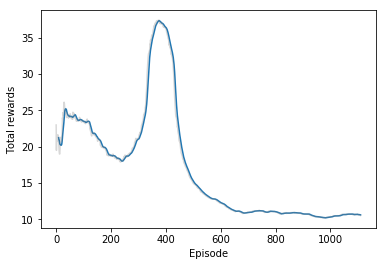

In [23]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

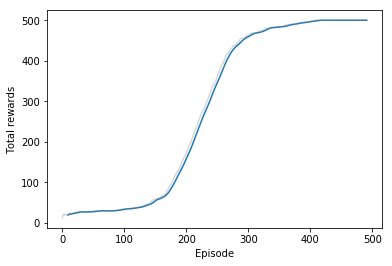

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

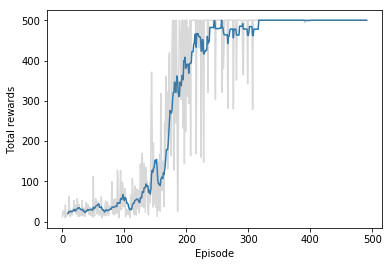

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [65]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [67]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.